#Importing The Necessary Libraries & Loading the Data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/Shadowfox_intern/HousingData.csv")

Mounted at /content/drive


##Feature Engineering & Initial Preprocessing

In [2]:
df['LOG_CRIM'] = np.log1p(df['CRIM'])
df['LOG_DIS'] = np.log1p(df['DIS'])
df['LOG_LSTAT'] = np.log1p(df['LSTAT'])

df['RM_LSTAT'] = df['RM'] * df['LSTAT']
df['AGE_NOX'] = df['AGE'] * df['NOX']

df['AGE_BIN'] = pd.cut(df['AGE'], bins=[0, 35, 70, 100], labels=["Young", "Middle", "Old"])
df = pd.get_dummies(df, columns=["AGE_BIN"], drop_first=True)


##Data Cleaning and Enhanced Preprocessing

Dataset shape after dropping nulls: (394, 21)


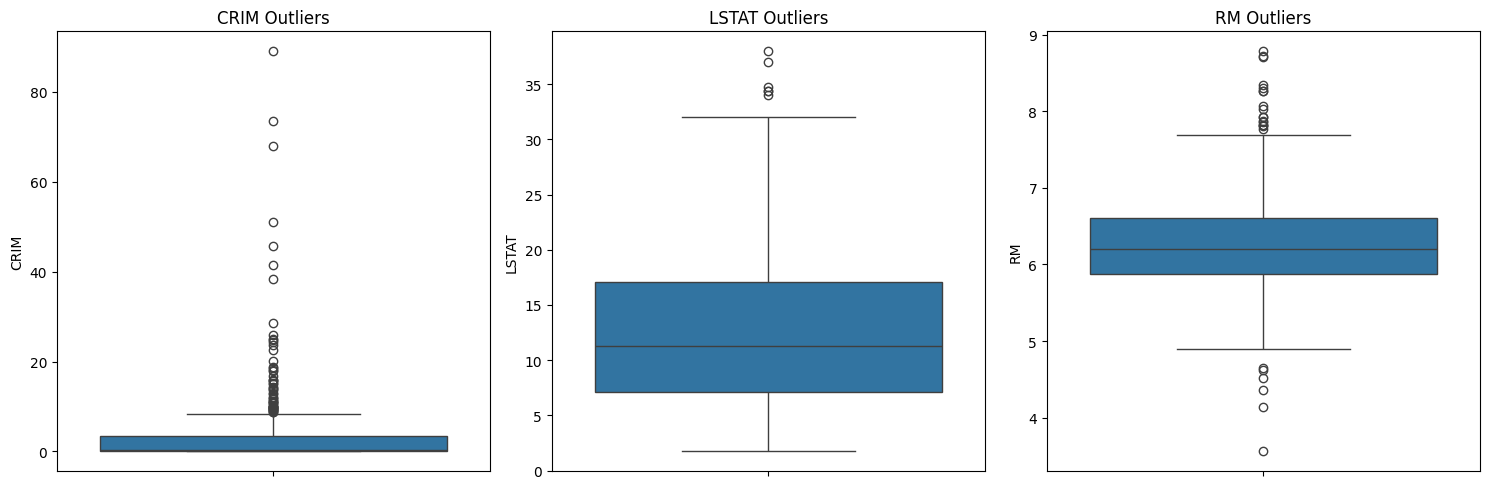

In [3]:
data = df.dropna()
print(f"Dataset shape after dropping nulls: {data.shape}")

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data['CRIM'])
plt.title('CRIM Outliers')

plt.subplot(1, 3, 2)
sns.boxplot(data['LSTAT'])
plt.title('LSTAT Outliers')

plt.subplot(1, 3, 3)
sns.boxplot(data['RM'])
plt.title('RM Outliers')

plt.tight_layout()
plt.show()

##Data Exploration

<class 'pandas.core.frame.DataFrame'>
Index: 394 entries, 0 to 504
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CRIM            394 non-null    float64
 1   ZN              394 non-null    float64
 2   INDUS           394 non-null    float64
 3   CHAS            394 non-null    float64
 4   NOX             394 non-null    float64
 5   RM              394 non-null    float64
 6   AGE             394 non-null    float64
 7   DIS             394 non-null    float64
 8   RAD             394 non-null    int64  
 9   TAX             394 non-null    int64  
 10  PTRATIO         394 non-null    float64
 11  B               394 non-null    float64
 12  LSTAT           394 non-null    float64
 13  MEDV            394 non-null    float64
 14  LOG_CRIM        394 non-null    float64
 15  LOG_DIS         394 non-null    float64
 16  LOG_LSTAT       394 non-null    float64
 17  RM_LSTAT        394 non-null    float64


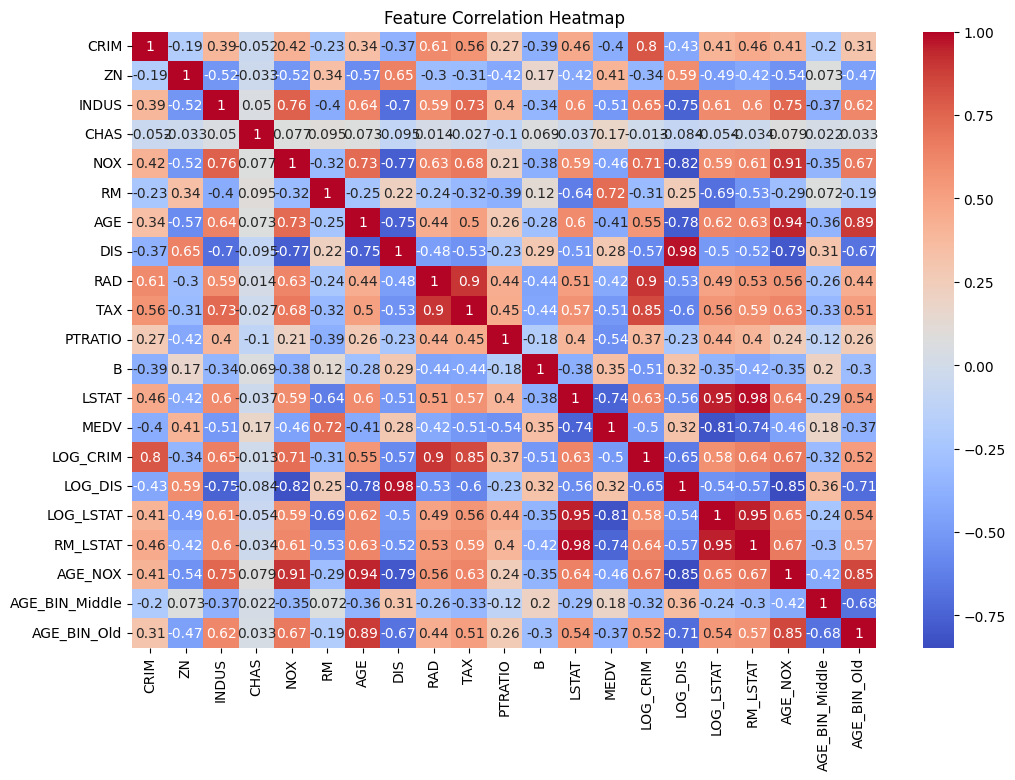

In [4]:
print(data.info())
print(data.describe())

plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

##Model Preparation and Training

In [5]:
X = data.drop("MEDV", axis=1)
y = data["MEDV"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("--- Baseline Linear Regression ---")
print(f"R² Score: {r2_lr:.4f}")
print(f"RMSE: {rmse_lr:.4f}")


poly_model = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), LinearRegression())
poly_model.fit(X_train, y_train)

y_pred_poly = poly_model.predict(X_test)
r2_poly = r2_score(y_test, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly))

print("\n--- Polynomial Regression ---")
print(f"R² Score: {r2_poly:.4f}")
print(f"RMSE: {rmse_poly:.4f}")

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

print("\n--- Model Comparison ---")
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"--- {name} ---")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}\n")

--- Baseline Linear Regression ---
R² Score: 0.6805
RMSE: 5.1913

--- Polynomial Regression ---
R² Score: 0.6613
RMSE: 5.3450

--- Model Comparison ---
--- Decision Tree ---
R² Score: 0.7030
RMSE: 5.0047

--- Gradient Boosting ---
R² Score: 0.6714
RMSE: 5.2644



##Robust Evaluation & Fine-Tuning

In [6]:
gbr = GradientBoostingRegressor(random_state=42)
cv_scores = cross_val_score(gbr, X, y, cv=5, scoring='r2')

print("--- Gradient Boosting Cross-Validation ---")
print(f"CV R² Scores: {cv_scores}")
print(f"Average CV R² Score: {np.mean(cv_scores):.4f}")


param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\n--- Hyperparameter Tuning Results ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validated R² Score: {grid_search.best_score_:.4f}")


best_model = grid_search.best_estimator_
y_pred_final = best_model.predict(X_test)

final_mae = mean_absolute_error(y_test, y_pred_final)
final_mse = mean_squared_error(y_test, y_pred_final)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, y_pred_final)

print("\n--- Final Tuned Model Performance on Test Set ---")
print(f"MAE: {final_mae:.4f}")
print(f"MSE: {final_mse:.4f}")
print(f"RMSE: {final_rmse:.4f}")
print(f"R² Score: {final_r2:.4f}")

--- Gradient Boosting Cross-Validation ---
CV R² Scores: [0.69021617 0.84608573 0.70421314 0.34999488 0.53102163]
Average CV R² Score: 0.6243

--- Hyperparameter Tuning Results ---
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best Cross-Validated R² Score: 0.8657

--- Final Tuned Model Performance on Test Set ---
MAE: 2.8123
MSE: 26.7290
RMSE: 5.1700
R² Score: 0.6831


##Visualization of Final Model


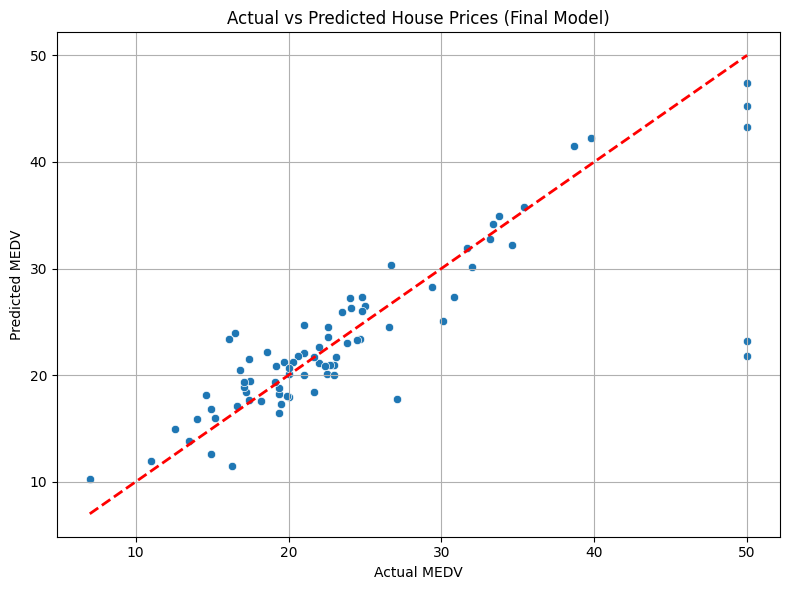

In [7]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_final)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual MEDV")
plt.ylabel("Predicted MEDV")
plt.title("Actual vs Predicted House Prices (Final Model)")
plt.grid(True)
plt.tight_layout()
plt.show()
